# Proyecto Final: Online Retail Analysis

<div class="alert alert-info", role="alert">
    <h2>🎯 </h2>
    <p>
      El objetivo de este proyecto es poner en práctica todo lo visto y aprendido durante el curso de <a href="https://platzi.com/cursos/python-data-science/">Python para Ciencia de Datos</a>, en el cuál vemos la aplicación de herramientas para el análisis de datos como son:
      <ul>
        <li>numpy</li>
        <li>pandas</li>
        <li>matplotlib</li>
      </ul>
    </p>
</div>

El objetivo principal del análisis es entender los patrones de compra, identificar los productos más vendidos y los clientes más valiosos, y detectar posibles tendencias en las ventas. 
<br>
Algunas de las preguntas a responder son:
- ¿Cuáles son los productos más vendidos?
- ¿Que productos tienen mayor tasa de devolución?
- ¿Quiénes son los clientes más valiosos?
- ¿Hay patrones estacionales o tendencias en las ventas?
- ¿Cuáles son los países con mayores ventas?

## Librerias y carga de los datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append("..")

import modules.utils.paths as path

In [4]:
file_path = path.data_raw_dir("online_retail.csv")
retail_df = pd.read_csv(file_path)

## Exploración inicial

In [5]:
total_rows, total_cols = retail_df.shape
print(f"Filas: {total_rows} \nColumnas: {total_cols}")
retail_df.sample(3)

Filas: 541909 
Columnas: 8


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
218133,556017,22558,CLOTHES PEGS RETROSPOT PACK 24,12,2011-06-08 11:56:00,1.65,15382.0,United Kingdom
181377,552467,21868,POTTING SHED TEA MUG,18,2011-05-09 15:29:00,1.25,15249.0,United Kingdom
210022,555276,21936,RED RETROSPOT PICNIC BAG,1,2011-06-01 17:28:00,5.79,NaN,United Kingdom


In [6]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [7]:
retail_df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [8]:
duplicated_rows = retail_df.duplicated().sum()
duplicated_proportion = round(duplicated_rows/len(retail_df) * 100, 2)
print(f"Registros duplicados: {duplicated_rows} \nProporción: {duplicated_proportion}")

Registros duplicados: 5268 
Proporción: 0.97


In [9]:
missing_values = retail_df.isna().sum().sum()
missing_proportion = round(missing_values/len(retail_df) * 100, 2)
print(f"Valores faltantes: {missing_values} \nProporción: {missing_proportion}")

Valores faltantes: 136534 
Proporción: 25.2


**Observaciones**
- El Dataset cuenta con 541,909 registros y 8 columnas (características).
- Tenemos 3 tipos de datos: `float64`, `int64` y `object`.
- La columna `InvoiceDate` que representa la **fecha** de compra tiene un tipo de dato incorrecto (`object`).
- El $0.97\%$ de los registros estan duplicados.
- El $25.2\%$ de los registros son valores faltantes.

## Limpieza

### Duplicados y valores faltantes 

In [10]:
retail_cleaned = retail_df.drop_duplicates()
print(f"Duplicados: {retail_cleaned.duplicated().sum()}")

Duplicados: 0


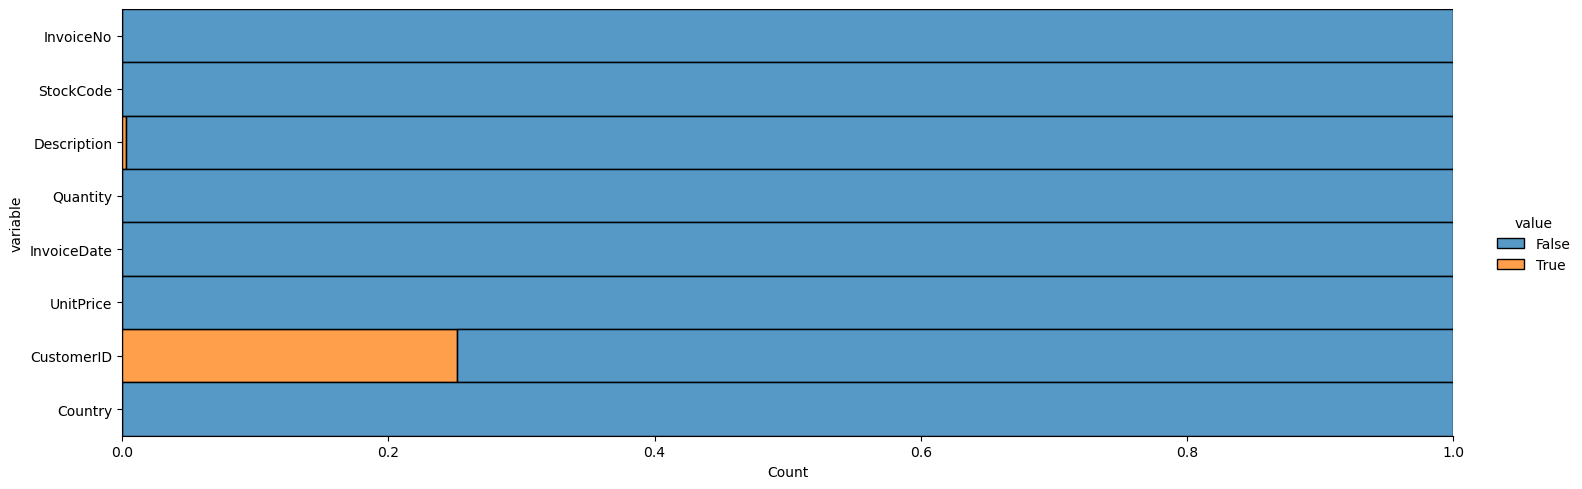

In [11]:
(
  retail_cleaned
  .isna()
  .melt()
  .pipe(
    lambda df: (
      sns.displot(
        data=df,
        y="variable",
        hue="value",
        multiple= "fill",
        aspect=3
      )
    )
  )
)
plt.show()

In [12]:
total_rows = retail_df.shape[0]
na_variables = retail_df.isna().sum()
na_variables = na_variables[na_variables > 0]
na_variables_proportion = na_variables / total_rows * 100

print("Total de valores faltantes:\n", na_variables)
print("-"*35)
print("Proporción de valores faltantes:\n", na_variables_proportion)

Total de valores faltantes:
 Description      1454
CustomerID     135080
dtype: int64
-----------------------------------
Proporción de valores faltantes:
 Description     0.268311
CustomerID     24.926694
dtype: float64


Por practicidad eliminaremos aquellos registros que tengan algún valor faltante en una de las columnas `Description` y `CustomerID`.

In [13]:
retail_cleaned = retail_cleaned.dropna(subset=["CustomerID"])
retail_cleaned.isna().sum().sum()

0

### Corrección en el tipo de dato

In [14]:
retail_cleaned["InvoiceDate"] = pd.to_datetime(retail_cleaned["InvoiceDate"])

retail_cleaned.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

## Definición de nuevas columnas

Columnas a añadir al DataFrame:
- Total Amount: Total de la compra, se obtiene de multiplicar la cantidad por el precio unitario.
- Year: Año de la compra, se extrae de la fecha de factura.
- Month: Mes de la compra, se extrae de la fecha de factura.
- Semestre: Semestre del año al que pertenece el mes, donde:
  - **1ser Semestre**: Enero a Junio
  - **2do Semestre**: Julio a Diciembre
- Quaerter: Trimestre del año al que pertenece el mes, donde:
  - **1er Trimestre**: Enero, Febrero y Marzo:
  - **2do Trimestre**: Abril, Mayo y Junio
  - **3er Trimestre**: Julio, Agosto y Semptiembre
  - **4to Trimestre**: Octubre, Noviembre y Diciembre

In [15]:
retail_cleaned["TotalAmount"] = retail_cleaned["Quantity"] * retail_cleaned["UnitPrice"]
retail_cleaned["Year"] = retail_cleaned["InvoiceDate"].dt.year
retail_cleaned["Month"] = retail_cleaned["InvoiceDate"].dt.month

In [16]:
retail_cleaned.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount,Year,Month
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010,12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010,12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,12


In [17]:
# Función para calcular cual es el trimestre del año
def quarter_of_year(value):
  if value in [1, 2, 3]:
    return "Q1"
  elif value in [4, 5, 6]:
    return "Q2"
  elif value in [7, 8, 9]: 
    return "Q3"
  else:
    return "Q4"

In [18]:
retail_cleaned["Semester"] = retail_cleaned["Month"].apply(lambda month: 1 if month <= 6 else 2)
retail_cleaned["Quaerter"] = retail_cleaned["Month"].apply(quarter_of_year)

In [19]:
retail_cleaned.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount,Year,Month,Semester,Quaerter
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010,12,2,Q4
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,12,2,Q4
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010,12,2,Q4
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,12,2,Q4
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,12,2,Q4


**Observaciones**
- Con el valor del total de compra en una columna especifica podremos realizar operaciones y análisis con mayor eficiencia al no realizar multiples veces el mismo cálculo.
- A partir de los datos de año, mes, semestre y trimestres podremos realizar análisis mas enfocados en determinados momentos del año. 

## Análisis

Ya teninedo los datos limpios y preparados, procederemos a responder las preguntas desglozadas al inicio del notebook:
- ¿Cuáles son los productos más vendidos?
- ¿Quiénes son los clientes más valiosos?
- ¿Hay patrones estacionales o tendencias en las ventas?
- ¿Qué factores contribuyen a las compras repetidas?

### 1. ¿Cuáles son los productos más vendidos?

Ante esta pregunta, podemos discrepar entre los productos más vendidos vs los productos con mayores ingresos totales ($).

In [20]:
# 10 productos más vendidos en total:
best_sellers = retail_cleaned.groupby("Description")["Quantity"].sum().sort_values(ascending=False).head(10)
most_incomes = retail_cleaned.groupby("Description")["TotalAmount"].sum().sort_values(ascending=False).head(10)

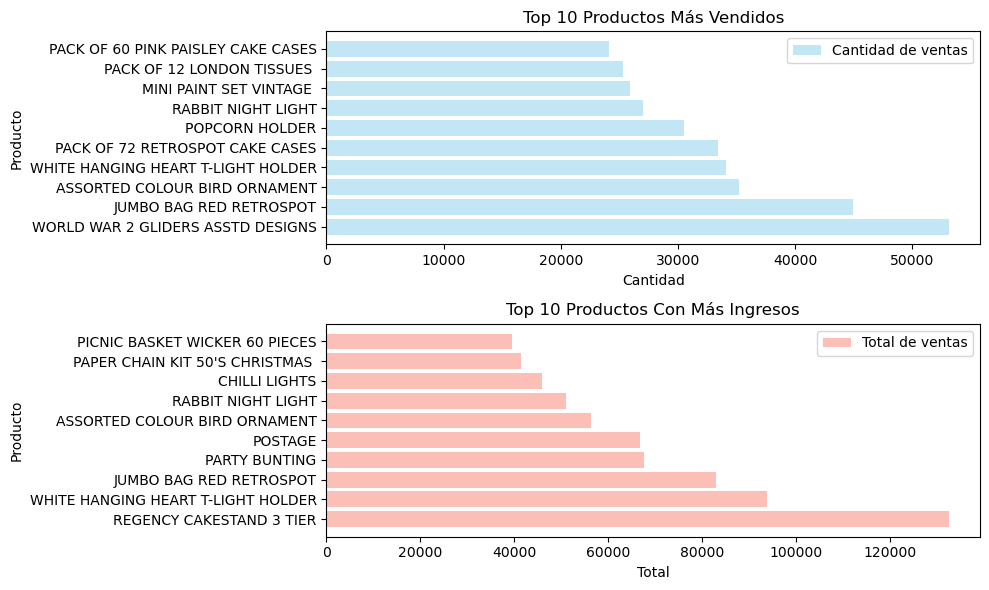

In [21]:
fig, axes =  plt.subplots(nrows=2, ncols=1, figsize=(10,6))

axes[0].barh(
  best_sellers.index.to_list(), 
  best_sellers,
  label="Cantidad de ventas",
  color="skyblue",
  alpha=0.5
)
axes[0].legend()

axes[0].set_title("Top 10 Productos Más Vendidos")
axes[0].set_xlabel("Cantidad")
axes[0].set_ylabel("Producto")


axes[1].barh(
  most_incomes.index.to_list(), 
  most_incomes,
  label="Total de ventas",
  color="salmon",
  alpha=0.5
)
axes[1].legend()

axes[1].set_title("Top 10 Productos Con Más Ingresos")
axes[1].set_xlabel("Total")
axes[1].set_ylabel("Producto")

plt.tight_layout()
plt.show()